In [1]:
"""
A prototype implementation of Use Case 9
"""

import xarray as xr
import os
import numpy as np
from ipywidgets import interact
# Needed for current resampling implementation
from mpl_toolkits import basemap
import time
# Pretty plots on maps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
# For linear regression calculation
from scipy import stats
%matplotlib inline

In [2]:
# This is just a prototype, hence the hard coded paths
CLOUD_ECV_PATH = '/home/ccitbx/cci_data/cloud/2008/'
AEROSOL_ECV_PATH = '/home/ccitbx/cci_data/aerosol/2008_monthly/'

In [3]:
# Define the functions that the prototype is going to use

def read_data(path):
    """
    Read in multiple netCDF files and combine them in an xarray dataset.

    :rtype: xr.Dataset
    :param path: Path to the folder
    :return: The resulting dataset
    """
    path = path + os.sep + '*.nc'
    print(path)
    dataset = xr.open_mfdataset(path, concat_dim='time')
    return dataset

class Plotter:
    def __init__(self, datasets, extents=None):
        """
        A helper class for interactive plotting.
        This is because interact() can't pass keyword arguments
        that don't define a widget to the desired function.
        
        datasets: a dictionary of datsets, keys have to correspond to names 
        in 'plot_datasets'
        extent: a list [lat,lat,lon,lon] that defines the bounding box to show
        in the plot. If not provided, a global plot is made
        """
        self.datasets = datasets
        self.extents = extents
        
    def setup_scatter(self, x, y, correlation):
        """
        Set up a scatter plot.
        
        :param x: xr.DataArray on x axis
        :param y: xr.DataArray on y axis
        :param correlation: A correlation xr.Dataset based on x and y.
        """
        self.scatter_params = {'x':x, 'y':y, 'correlation':correlation}
        
    def plot_datasets(self, names, t):
        """
        A function for interactive plotting.
        """
        array_slice = self.datasets[names].isel(time=t)
        fig=plt.figure(figsize=(16, 8))
        ax = plt.axes(projection=ccrs.PlateCarree())
        
        if self.extents:
            ax.set_extent(self.extents, ccrs.PlateCarree())
        else:
            ax.set_global()
        ax.coastlines()
        array_slice.plot.contourf(ax=ax, transform=ccrs.PlateCarree())
        
    def plot_scatter(self, t):
        x = self.scatter_params['x'].isel(time=t).values.flatten()
        y = self.scatter_params['y'].isel(time=t).values.flatten()
    
    
        # This is to ignore the NaN values in aerosol
        xm = np.ma.masked_array(x,mask=np.isnan(y)).compressed()
        ym = np.ma.masked_array(y,mask=np.isnan(y)).compressed()
    
        slope = self.scatter_params['correlation'].slope.isel(time=t).values
        intercept = self.scatter_params['correlation'].intercept.isel(time=t).values
        r_value = self.scatter_params['correlation'].r_value.isel(time=t).values
        p_value = self.scatter_params['correlation'].p_value.isel(time=t).values
        std_err = self.scatter_params['correlation'].std_err.isel(time=t).values
        print("Slope: " + str(slope))
        print("Intercept: " + str(intercept))
        print("R squared: " + str(r_value*r_value))
        print("P value: " + str(p_value))
        print("Standard error of the estimate: " + str(std_err))
        line = slope*x+intercept
    
        fig=plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(111)
        plt.plot(x,y,'.',x,line,'r-')
        ax.set_xlabel(self.scatter_params['x'].name)
        ax.set_ylabel(self.scatter_params['y'].name)
        plt.show()
    
    
def resample_slice(slice_, grid_lon, grid_lat, order=1):
    """
    Resample a single time slice of a larger xr.DataArray

    :param slice: xr.DataArray single slice
    :param grid_lon: meshgrid of longitudes for the new grid
    :param grid_lat: meshgrid of latitudes for the new grid
    :param order: Interpolation method 0 - nearest neighbour, 1 - bilinear (default), 3 - cubic spline
    :return: xr.DataArray, resampled slice
    """
    result = basemap.interp(slice_.values, slice_['lon'].data, slice_['lat'].data, grid_lon, grid_lat)
    return xr.DataArray(result)


def resample_array(array, lon, lat, order=1):
    """
    Resample the given xr.DataArray to a new grid defined by grid_lat and grid_lon

    :param array: xr.DataArray with lat,lon and time coordinates
    :param lat: 'lat' xr.DataArray attribute for the new grid
    :param lon: 'lon' xr.DataArray attribute for the new grid
    :param order: 0 for nearest-neighbor interpolation, 1 for bilinear interpolation,
    3 for cubic spline (default 1). order=3 requires scipy.ndimage.
    :return: None, changes 'array' in place.
    """
    # Don't do anything if this DataArray has different dims than expected
    if 'time' not in array.dims or 'lat' not in array.dims or 'lon' not in array.dims:
        return array

    #if array.dims != (('time','lat','lon')):
    #    return array

    print(array.name)
    print(array.dims)

    grid_lon, grid_lat = np.meshgrid(lon.data, lat.data)
    kwargs = {'grid_lon':grid_lon, 'grid_lat':grid_lat}
    temp_array = array.groupby('time').apply(resample_slice, **kwargs)
    chunks = list(temp_array.shape[1:])
    chunks.insert(0,1)
    return xr.DataArray(temp_array.values,
                        name = array.name,
                        dims = array.dims,
                        coords = {'time':array.time, 'lat':lat, 'lon':lon},
                        attrs = array.attrs).chunk(chunks=chunks)

def correlation_analysis(array_x, array_y):
    """
    Perform correlation analysis on the provided xr.dataArray objects.
    
    :param array_x: xr.DataArray whose values are on the horizontal axis of the scatter plot.
    :param array_y: xr.DataArray whose values are on the vertical axis of the scatter plot. E.g.
    the dependent variable.
    :return: xr.Dataset object that contains the time-series of correlation parameters, as well as the 
    spatial correlation data array.
    """

    ret_dataset = xr.Dataset()
    slope_list = list()
    intercept_list = list()
    r_value_list = list()
    p_value_list = list()
    std_err_list = list()
    rr_list = list()
    
    # Looping using the time dimension. Maybe there's a better way
    for t in range(len(array_x.time.values)):
        x = array_x.isel(time=t).values.flatten()
        y = array_y.isel(time=t).values.flatten()
    
        # This is to ignore the NaN values in array_y
        xm = np.ma.masked_array(x,mask=np.isnan(y)).compressed()
        ym = np.ma.masked_array(y,mask=np.isnan(y)).compressed()

        # Do a linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(xm,ym)
        
        coeffs = [slope, intercept]

        fitted_y = np.polyval(coeffs, x)
        diff_y = y - fitted_y

        diff_y = diff_y.reshape(len(array_x.lat),len(array_x.lon),1)
        time_dim = list([array_x.time[t]])
        
        array_slice = xr.DataArray((abs(diff_y)),
                         name = 'spatial_correlation',
                         dims = ['lat','lon','time'],
                         coords = {'lat':array_x.lat, 'lon':array_x.lon, 'time':time_dim})
        
        # Construct the 1D linear regression variables
        slope_list.append(slope)
        intercept_list.append(intercept)
        r_value_list.append(r_value)
        p_value_list.append(p_value)
        std_err_list.append(std_err)
        rr_list.append(r_value*r_value)
        
        # Construct the 3D DataArray variable
        if t == 0:
            ret_dataset['spatial_correlation'] = array_slice
        else:
            temp_ds = xr.Dataset()
            temp_ds['spatial_correlation'] = array_slice
            ret_dataset = xr.concat([ret_dataset, temp_ds], 'time')
    
    # Add the 1D variables to the return dataset
    slope = xr.DataArray(slope_list,
                        name = 'slope',
                        dims = ['time'],
                        coords = {'time':array_x.time})
    intercept = xr.DataArray(intercept_list,
                        name = 'intercept',
                        dims = ['time'],
                        coords = {'time':array_x.time})
    r_value = xr.DataArray(r_value_list,
                        name = 'r_value',
                        dims = ['time'],
                        coords = {'time':array_x.time})
    p_value = xr.DataArray(p_value_list,
                        name = 'p_value',
                        dims = ['time'],
                        coords = {'time':array_x.time})
    std_err = xr.DataArray(std_err_list,
                        name = 'std_err',
                        dims = ['time'],
                        coords = {'time':array_x.time})
    r_squared = xr.DataArray(rr_list,
                        name = 'r_squared',
                        dims = ['time'],
                        coords = {'time':array_x.time})
    
    ret_dataset['slope'] = slope
    ret_dataset['intercept'] = intercept
    ret_dataset['r_value'] = r_value
    ret_dataset['p_value'] = p_value
    ret_dataset['std_err'] = std_err
    ret_dataset['r_squared'] = r_squared
    
    return ret_dataset 

In [4]:
# Read in data
ds_clouds = read_data(CLOUD_ECV_PATH)
ds_aerosol = read_data(AEROSOL_ECV_PATH)

/home/ccitbx/cci_data/cloud/2008//*.nc
/home/ccitbx/cci_data/aerosol/2008_monthly//*.nc


In [5]:
# Rename the aerosol dataset's coordinates to correspond with clouds
ds_aerosol.rename({'latitude':'lat', 'longitude':'lon'},inplace=True)

# Select the variables of interest
cc_total = ds_clouds.cc_total
aerosol = ds_aerosol.AOD550_mean

In [6]:
print(aerosol)

<xarray.DataArray 'AOD550_mean' (time: 12, lat: 180, lon: 360)>
dask.array<concate..., shape=(12, 180, 360), dtype=float64, chunksize=(1, 180, 360)>
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
Attributes:
    long_name: mean aerosol optical density at 550 nm
    standard_name: atmosphere_optical_thickness_due_to_ambient_aerosol
    units: 1
    valid_range: [ 0.  4.]


In [7]:
# Regrid the cc_total to the grid used for aerosol
cc_total_resampled = resample_array(cc_total, aerosol['lon'], aerosol['lat'], order=1)

cc_total
('time', 'lat', 'lon')


In [8]:
# Define plotting parameters
names = ['clouds', 'aerosol']
ds = {'clouds':cc_total_resampled, 'aerosol':aerosol}

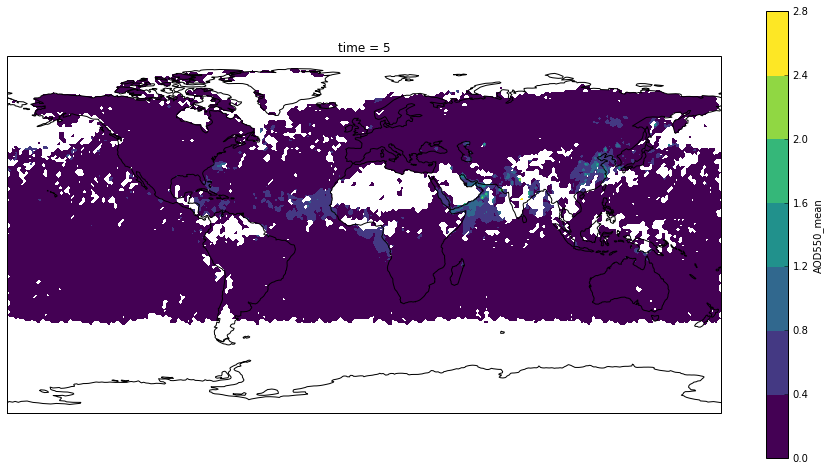

In [9]:
disp = Plotter(ds)
interact(disp.plot_datasets, names = names, t=(0,11,1))

In [10]:
# Select a spatial subset (Africa)
lat_slice = slice(-40., 40.)
lon_slice = slice(-20., 60.)
cc_total_sub = cc_total_resampled.sel(lat=lat_slice,lon=lon_slice)
aerosol_sub = aerosol.sel(lat=lat_slice, lon=lon_slice)

# Select a time subset, feb - sept. Selecting by indices now, as the
# time definition is not uniform for both datasets
time_slice = slice(1,10)
cc_total_sub = cc_total_sub.isel(time=time_slice)
aerosol_sub = aerosol_sub.isel(time=time_slice)


In [11]:
print(cc_total_sub)
print(aerosol_sub)

<xarray.DataArray 'cc_total' (time: 9, lat: 80, lon: 80)>
dask.array<getitem..., shape=(9, 80, 80), dtype=float64, chunksize=(1, 80, 80)>
Coordinates:
  * lon      (lon) float32 -19.5 -18.5 -17.5 -16.5 -15.5 -14.5 -13.5 -12.5 ...
  * lat      (lat) float32 -39.5 -38.5 -37.5 -36.5 -35.5 -34.5 -33.5 -32.5 ...
  * time     (time) float32 2.4545e+06 2.45453e+06 2.45456e+06 2.45459e+06 ...
Attributes:
    long_name: cloud fraction
    standard_name: cloud_area_fraction
    units: %
    valid_min: 0.0
    valid_max: 1.0
<xarray.DataArray 'AOD550_mean' (time: 9, lat: 80, lon: 80)>
dask.array<getitem..., shape=(9, 80, 80), dtype=float64, chunksize=(1, 80, 80)>
Coordinates:
  * lat      (lat) float32 -39.5 -38.5 -37.5 -36.5 -35.5 -34.5 -33.5 -32.5 ...
  * lon      (lon) float32 -19.5 -18.5 -17.5 -16.5 -15.5 -14.5 -13.5 -12.5 ...
  * time     (time) int64 1 2 3 4 5 6 7 8 9
Attributes:
    long_name: mean aerosol optical density at 550 nm
    standard_name: atmosphere_optical_thickness_due_to_amb

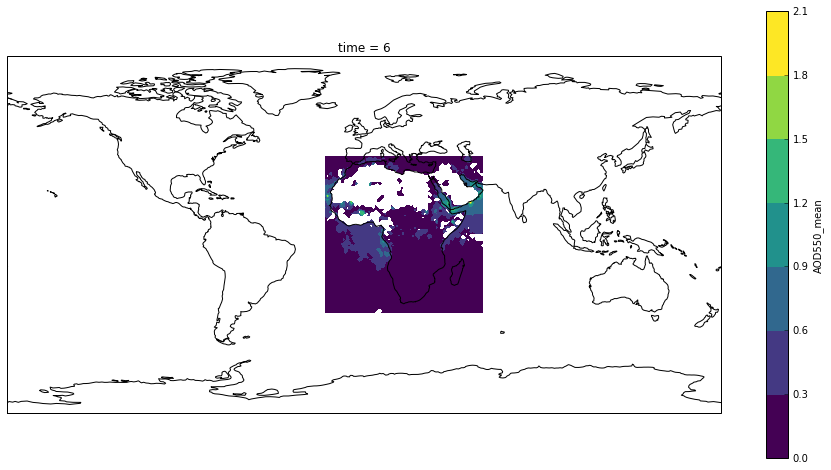

In [12]:
# Plot the subset
ds = {'clouds':cc_total_sub, 'aerosol':aerosol_sub}

disp = Plotter(ds)
interact(disp.plot_datasets, names = names, t=(0,8))

In [13]:
correlation_res = correlation_analysis(cc_total_sub, aerosol_sub)

In [14]:
print(correlation_res)

<xarray.Dataset>
Dimensions:              (lat: 80, lon: 80, time: 9)
Coordinates:
  * lon                  (lon) float32 -19.5 -18.5 -17.5 -16.5 -15.5 -14.5 ...
  * lat                  (lat) float32 -39.5 -38.5 -37.5 -36.5 -35.5 -34.5 ...
  * time                 (time) float32 2.4545e+06 2.45453e+06 2.45456e+06 ...
Data variables:
    spatial_correlation  (lat, lon, time) float64 0.07999 0.0793 0.1043 ...
    slope                (time) float64 -0.1259 0.1058 0.04157 0.03423 ...
    intercept            (time) float64 0.2729 0.1261 0.158 0.1273 0.1101 ...
    r_value              (time) float64 -0.1061 0.1383 0.04242 0.05714 ...
    p_value              (time) float64 1.114e-14 3.207e-24 0.002234 ...
    std_err              (time) float64 0.01625 0.01037 0.01359 0.008413 ...
    r_squared            (time) float64 0.01125 0.01911 0.001799 0.003266 ...


In [15]:
# Plot the correlation
ds = {'clouds':cc_total_sub, 'aerosol':aerosol_sub, 'correlation':correlation_res.spatial_correlation}
names = ['clouds','aerosol','correlation']

disp = Plotter(ds)
disp.setup_scatter(cc_total_sub, aerosol_sub, correlation_res)

Slope: 0.12107952306175439
Intercept: 0.11011245783984867
R squared: 0.0226892620204
P value: 1.6936541112923157e-27
Standard error of the estimate: 0.011079658422860069


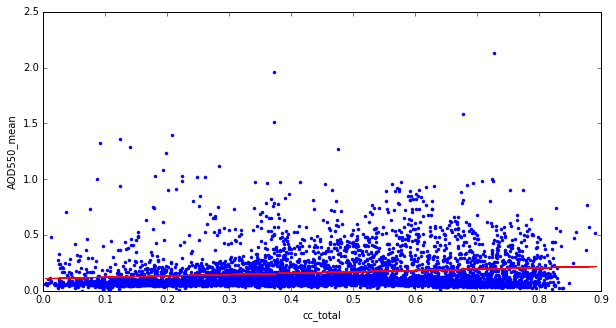

In [16]:
interact(disp.plot_scatter, t=(0,8))

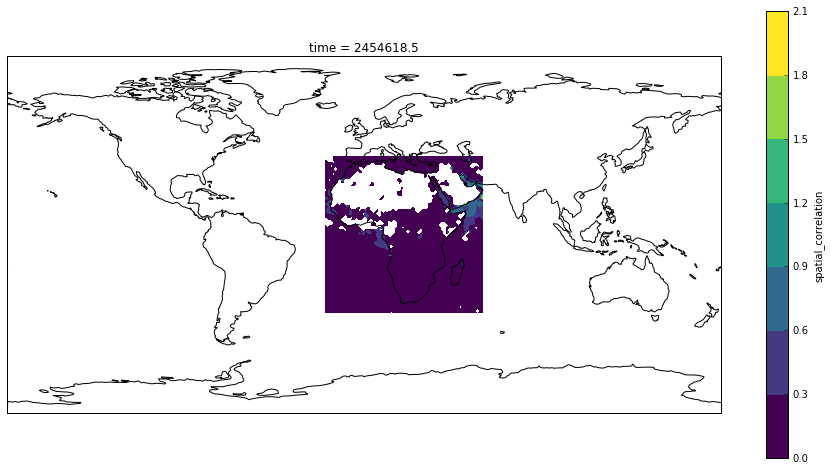

In [17]:
interact(disp.plot_datasets, names = names, t=(0,8))